In [94]:
import pandas as pd
import numpy as np
import texthero as hero
from texthero import preprocessing as ppe
from texthero import visualization as viz
import spacy
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import re
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor

In [2]:
train_df = pd.read_csv('Train_Data.csv')
test_df = pd.read_csv('Test_Data.csv')

In [3]:
train_df.head()

,text,author,controversiality,parent_text,parent_score,parent_votes,parent_author,parent_controversiality,Score
0,i must be retarded i thought it meant con lawl...,['calantus'],0,"It's quite unfair to call Hillary Clinton a ""c...",245,245,Whisper,0,-8
1,DOWNMODDED FOR IRRELEVANCE? ISN'T THAT HOW THI...,['Shadowrose'],0,upmodded for awesome kindness,32,32,b3mus3d,0,-16
2,"THAT WAS SUPPOSED TO MEAN "" BY A PLACE WHERE P...",['NExusRush'],0,"What the hell does ""because its by a golf cour...",12,12,mr_jellyneck,0,-7
3,I THOUGHT EVERYONE DID; ITS FUCKING DELICIOUS :\,['R0N_SWANS0N'],0,NICE TRY JENNIFER! I KNOW IT'S YOU AND I KNOW...,117,117,ometzo,0,67
4,"Great work, Zhesbe! I'd give you a raise but y...",['reddums'],0,"""HEY BOSS COME LOOK AT WHAT I DID!""",1933,1933,Zhesbe,0,1348


In [4]:
test_df.head()

,text,author,controversiality,parent_text,parent_score,parent_votes,parent_author,parent_controversiality
0,Big deal. He once fought in the Napoleonic war...,['RecQuery'],0,Big deal. He was once shot with three arrows a...,438,438,illchopyourfaceoff,0
1,"I don't think the animal cares, either way, it...",['N4N4KI'],0,Animal cruelty is not a joke. It is not the s...,38,38,0_o,0
2,&GT; IT'S FAIRLY OBVIOUS YOU HAVE AN AGENDA HE...,['cometparty'],0,&gt;**You people** have time and time again sh...,16,16,[deleted],0
3,It's probably due to their skin looking supple...,['[deleted]'],0,I like women who are either naturally tan or a...,902,902,[deleted],0
4,kendrick lamar. he's like a poverty lupe fiasc...,['purrppassion'],0,who has the most overrated discography in hip ...,33,33,mr2good4you,0


In [5]:
train_df = train_df[['text', 'Score']]
test_df = test_df[['text']]

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4999 non-null   object
 1   Score   4999 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1015 non-null   object
dtypes: object(1)
memory usage: 8.1+ KB


### Text preprocessing 

In [8]:
custom_pipeline = [ppe.fillna, ppe.lowercase, ppe.remove_punctuation, ppe.remove_whitespace, 
                  ppe.remove_stopwords, ppe.remove_urls, ppe.remove_digits]

train_df['cleaned_text'] = hero.clean(train_df['text'], custom_pipeline)
test_df['cleaned_text'] = hero.clean(test_df['text'], custom_pipeline)

In [9]:
train_df.head()

,text,Score,cleaned_text
0,i must be retarded i thought it meant con lawl...,-8,must retarded thought meant con lawl oh we...
1,DOWNMODDED FOR IRRELEVANCE? ISN'T THAT HOW THI...,-16,downmodded irrelevance works
2,"THAT WAS SUPPOSED TO MEAN "" BY A PLACE WHERE P...",-7,supposed mean place people undoubtedly...
3,I THOUGHT EVERYONE DID; ITS FUCKING DELICIOUS :\,67,thought everyone fucking delicious \
4,"Great work, Zhesbe! I'd give you a raise but y...",1348,great work zhesbe give raise seem hand...


In [10]:
def lemmatizer(r):
    wnl = WordNetLemmatizer()
    words = nltk.word_tokenize(r)
    lemmatized_words = [wnl.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    return " ".join(lemmatized_words)

train_df['cleaned_text'] = train_df['cleaned_text'].apply(lemmatizer)
test_df['cleaned_text'] = test_df['cleaned_text'].apply(lemmatizer)

In [11]:
train_df.head()

,text,Score,cleaned_text
0,i must be retarded i thought it meant con lawl...,-8,must retarded thought meant con lawl oh well work
1,DOWNMODDED FOR IRRELEVANCE? ISN'T THAT HOW THI...,-16,downmodded irrelevance work
2,"THAT WAS SUPPOSED TO MEAN "" BY A PLACE WHERE P...",-7,supposed mean place people undoubtedly snake b...
3,I THOUGHT EVERYONE DID; ITS FUCKING DELICIOUS :\,67,thought everyone fucking delicious \
4,"Great work, Zhesbe! I'd give you a raise but y...",1348,great work zhesbe give raise seem handled


In [12]:
test_df.head()

,text,cleaned_text
0,Big deal. He once fought in the Napoleonic war...,big deal fought napoleonic war practically imm...
1,"I don't think the animal cares, either way, it...",think animal care either way dead
2,&GT; IT'S FAIRLY OBVIOUS YOU HAVE AN AGENDA HE...,gt fairly obvious agenda right agenda prevent ...
3,It's probably due to their skin looking supple...,probably due skin looking supple like tanned l...
4,kendrick lamar. he's like a poverty lupe fiasc...,kendrick lamar like poverty lupe fiasco better...


In [14]:
def spellcheck(s):
    spell = SpellChecker()
    misspelled = nltk.word_tokenize(s)
    check_spell = [spell.correction(word) for word in misspelled if word not in set(stopwords.words('english'))]
    return " ".join(check_spell)

In [15]:
train_df['cleaned_text'] = train_df['cleaned_text'].apply(spellcheck)
test_df['cleaned_text'] = test_df['cleaned_text'].apply(spellcheck)

In [16]:
train_df.drop('text', axis = 1, inplace = True)
test_df.drop('text', axis = 1, inplace = True)

In [67]:
def remove_special_characters(text):
    pattern = r'[^a-zA-Z]'
    text = re.sub(pattern, ' ', text)
    return text

train_df['cleaned_text'] = train_df['cleaned_text'].apply(remove_special_characters)
test_df['cleaned_text'] = test_df['cleaned_text'].apply(remove_special_characters)

In [68]:
train_df.head()

,cleaned_text,Score
0,must retarded thought meant con law oh well work,-8
1,downloaded irrelevance work,-16
2,supposed mean place people undoubtedly snake b...,-7
3,thought everyone fucking delicious,67
4,great work these give raise seem handled,1348


In [69]:
test_df.head()

,cleaned_text
0,big deal fought napoleonic war practically imm...
1,think animal care either way dead
2,it fairly obvious agenda right agenda prevent ...
3,probably due skin looking supple like tanned l...
4,kendrick lamar like poverty lupe fiasco better...


In [70]:
viz.top_words(train_df['cleaned_text'])

like                 776
people               620
would                531
one                  487
get                  484
                    ... 
thedreadredditord      1
vargas                 1
suggesting             1
reproducing            1
revive                 1
Name: cleaned_text, Length: 12287, dtype: int64

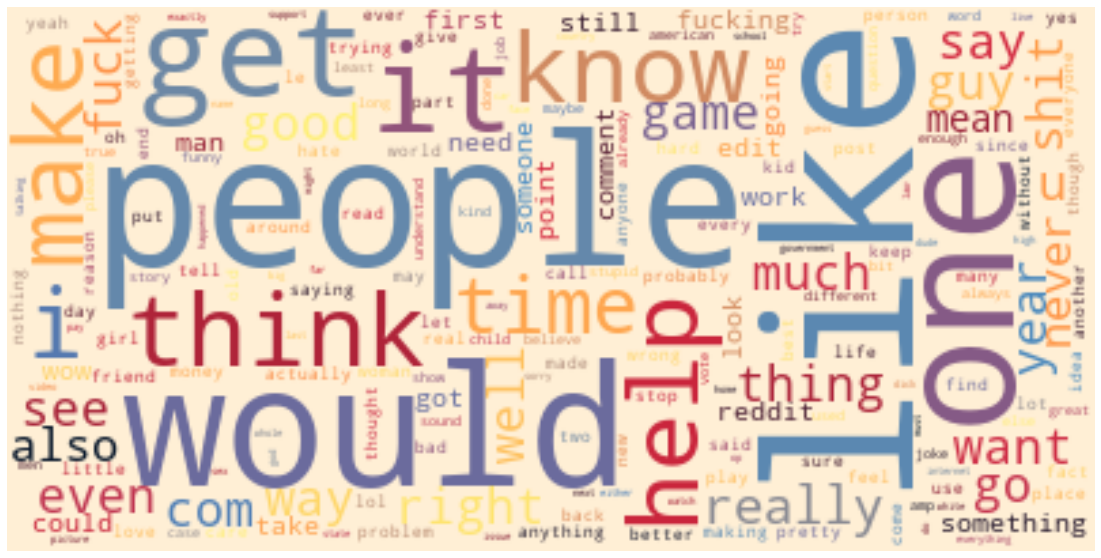

In [71]:
wordcloud = viz.wordcloud(train_df['cleaned_text'])

In [76]:
tfidf = TfidfVectorizer()
train_X = tfidf.fit_transform(train_df['cleaned_text']).toarray()
train_X = pd.DataFrame(train_X, columns=tfidf.get_feature_names())

In [77]:
test_X = tfidf.transform(test_df['cleaned_text']).toarray()
test_X = pd.DataFrame(test_X, columns=tfidf.get_feature_names())

In [79]:
train_df = pd.concat([train_df, train_X], axis = 1)

In [80]:
X = train_X
y = train_df.Score

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state = 42)

In [82]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [83]:
pred = lr.predict(X_val)

In [85]:
print('Root Mean Squared Error is: ', np.sqrt(mean_squared_error(y_val, pred)))

Root Mean Squared Error is:  1318713468624910.5


In [95]:
model = XGBRegressor()
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [96]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [97]:
pred = model.predict(X_val)

In [98]:
print('Root Mean Squared Error is: ', np.sqrt(mean_squared_error(y_val, pred)))

Root Mean Squared Error is:  203.46991248014217


In [99]:
target = model.predict(test_X)

In [101]:
res = pd.DataFrame(target)  
res.index = test_df.index 
res.columns = ["prediction"]
res.to_csv("submission.csv") 